# Geely Automobile 

A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts. 
 
They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:
- Which variables are significant in predicting the price of a car
- How well those variables describe the price of a car

Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the Americal market.

## Step 1: Reading and Understanding the Data

In [622]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [623]:
#Importing dataset
car_df = pd.read_csv('CarPrice_Assignment.csv')

In [624]:
#analyze the dataframe
car_df.head()

car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase   ...     enginesize  \
0  convertible        rwd          front       88.6   ...            130   
1  convertible        rwd          front       88.6   ...            130   
2    hatchback        rwd          front       94.5   ...            152   
3        sedan        fwd          front       99.8   ...            109   
4        sedan        4wd          front       99.4   ...            136   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \
0        mpfi       3.47    2.68              9.0        111     5000      21   
1        mpfi       3.47    2.68              9.0        111     5000      21   
2        mpfi       2.68    3.47              9.0        154     5000      19   
3        mpfi       3.19    3.40             10.0        102     5500      24   
4        mpfi       3.19    3.40              8.0        115     5500      18   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  

[5 rows x 26 columns]

In [625]:
# Total records in the dataframe is 205 and 26 columns
car_df.shape

(205, 26)

In [626]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [627]:
# percentage of missing values
round(car_df.isnull().sum()/len(car_df.index), 2)*100

car_ID              0.0
symboling           0.0
CarName             0.0
fueltype            0.0
aspiration          0.0
doornumber          0.0
carbody             0.0
drivewheel          0.0
enginelocation      0.0
wheelbase           0.0
carlength           0.0
carwidth            0.0
carheight           0.0
curbweight          0.0
enginetype          0.0
cylindernumber      0.0
enginesize          0.0
fuelsystem          0.0
boreratio           0.0
stroke              0.0
compressionratio    0.0
horsepower          0.0
peakrpm             0.0
citympg             0.0
highwaympg          0.0
price               0.0
dtype: float64

#### Seems like there is no null value in the dataframe , hence cleaning and imputing is not required

#### Creating model fitting function for reusability

In [628]:
def fit_LRM(X_train,Y_train):
    X_train = sm.add_constant(X_train)
    lm = sm.OLS(Y_train,X_train).fit() 
    print(lm.summary())
    return lm

In [629]:
def getVIF(X_train):
    # Calculate the VIFs for the new model
    vif = pd.DataFrame()
    X = X_train
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [630]:
def draw_categorical(column_name,df,title=None,hue=None):
       fig, ax=plt.subplots(figsize=(14,8))
       plt.title(title)
       ax = sns.countplot(data = df, x= column_name, order=df[column_name].value_counts().index,hue = hue) 
       ax.set(xlabel=column_name, ylabel="Count")

       for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., np.nan_to_num(p.get_height()), '%d' % int(np.nan_to_num(p.get_height())), 
                fontsize=12, color='black', ha='center', va='bottom')
       plt.xticks(rotation='vertical',fontsize=12)
       plt.show()

In [631]:
def draw_continous_plot(column_name,df,hue=None,title=None):
 sns.set(style="darkgrid")   
 sns.set_palette(sns.color_palette("hls",20))
 fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(20,8))
 ax[0].set_title("Distribution Plot")
 sns.distplot(df[column_name],ax=ax[0])
 ax[1].set_title("Box Plot")
 sns.boxplot(data =df, x=column_name,ax=ax[1],orient='v')
 plt.xticks(rotation='vertical',fontsize=12)
 plt.show() 

## Step 2 : Data Preparation

There is a variable named CarName which is comprised of two parts - the first word is the name of 'car company' and the second is the 'car model'. For example, chevrolet impala has 'chevrolet' as the car company name and 'impala' as the car model name. You need to consider only company name as the independent variable for model building. 

In [632]:
#Removing the car Name from the dataframe and renaming the column to Car Company
car_df['CarName']=car_df['CarName'].str.split(' ').str[0]
car_df.rename(index=str, columns={"CarName": "CarCompany"},inplace=True)

In [633]:
#analyze the dataframe
car_df.head()

car_ID  symboling   CarCompany fueltype aspiration doornumber      carbody  \
0       1          3  alfa-romero      gas        std        two  convertible   
1       2          3  alfa-romero      gas        std        two  convertible   
2       3          1  alfa-romero      gas        std        two    hatchback   
3       4          2         audi      gas        std       four        sedan   
4       5          2         audi      gas        std       four        sedan   

  drivewheel enginelocation  wheelbase   ...     enginesize  fuelsystem  \
0        rwd          front       88.6   ...            130        mpfi   
1        rwd          front       88.6   ...            130        mpfi   
2        rwd          front       94.5   ...            152        mpfi   
3        fwd          front       99.8   ...            109        mpfi   
4        4wd          front       99.4   ...            136        mpfi   

   boreratio  stroke compressionratio horsepower  peakrpm citympg  highwaympg  \
0       3.47    2.68              9.0        111     5000      21          27   
1       3.47    2.68              9.0        111     5000      21          27   
2       2.68    3.47              9.0        154     5000      19          26   
3       3.19    3.40             10.0        102     5500      24          30   
4       3.19    3.40              8.0        115     5500      18          22   

     price  
0  13495.0  
1  16500.0  
2  16500.0  
3  13950.0  
4  17450.0  

[5 rows x 26 columns]

In [634]:
# distinct Car Company to check all names are consistent or not ,certainly the names are incorrectly spelled 
car_df['CarCompany'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [635]:
#Correcting the incorrect names in the dataframe
car_df.CarCompany.replace(['Nissan', 'toyouta','porcshce','vw','vokswagen','maxda']
                        , ['nissan', 'toyota','porsche','volkswagen','volkswagen','mazda'], inplace=True)

In [636]:
#check the dataframe again
car_df['CarCompany'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [637]:
#checking the distinct value in dataframe ,Car ID is unique ,no duplicate values
car_df.nunique()

car_ID              205
symboling             6
CarCompany           22
fueltype              2
aspiration            2
doornumber            2
carbody               5
drivewheel            3
enginelocation        2
wheelbase            53
carlength            75
carwidth             44
carheight            49
curbweight          171
enginetype            7
cylindernumber        7
enginesize           44
fuelsystem            8
boreratio            38
stroke               37
compressionratio     32
horsepower           59
peakrpm              23
citympg              29
highwaympg           30
price               189
dtype: int64

In [638]:
#Drop the carId as it is unique and does not have any impact 
car_df.drop(['car_ID'], axis =1, inplace = True)

In [639]:
car_df.head()

symboling   CarCompany fueltype aspiration doornumber      carbody  \
0          3  alfa-romero      gas        std        two  convertible   
1          3  alfa-romero      gas        std        two  convertible   
2          1  alfa-romero      gas        std        two    hatchback   
3          2         audi      gas        std       four        sedan   
4          2         audi      gas        std       four        sedan   

  drivewheel enginelocation  wheelbase  carlength   ...     enginesize  \
0        rwd          front       88.6      168.8   ...            130   
1        rwd          front       88.6      168.8   ...            130   
2        rwd          front       94.5      171.2   ...            152   
3        fwd          front       99.8      176.6   ...            109   
4        4wd          front       99.4      176.6   ...            136   

   fuelsystem  boreratio stroke compressionratio  horsepower peakrpm  citympg  \
0        mpfi       3.47   2.68              9.0         111    5000       21   
1        mpfi       3.47   2.68              9.0         111    5000       21   
2        mpfi       2.68   3.47              9.0         154    5000       19   
3        mpfi       3.19   3.40             10.0         102    5500       24   
4        mpfi       3.19   3.40              8.0         115    5500       18   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  

[5 rows x 25 columns]

## Step3 - Data Analysis 

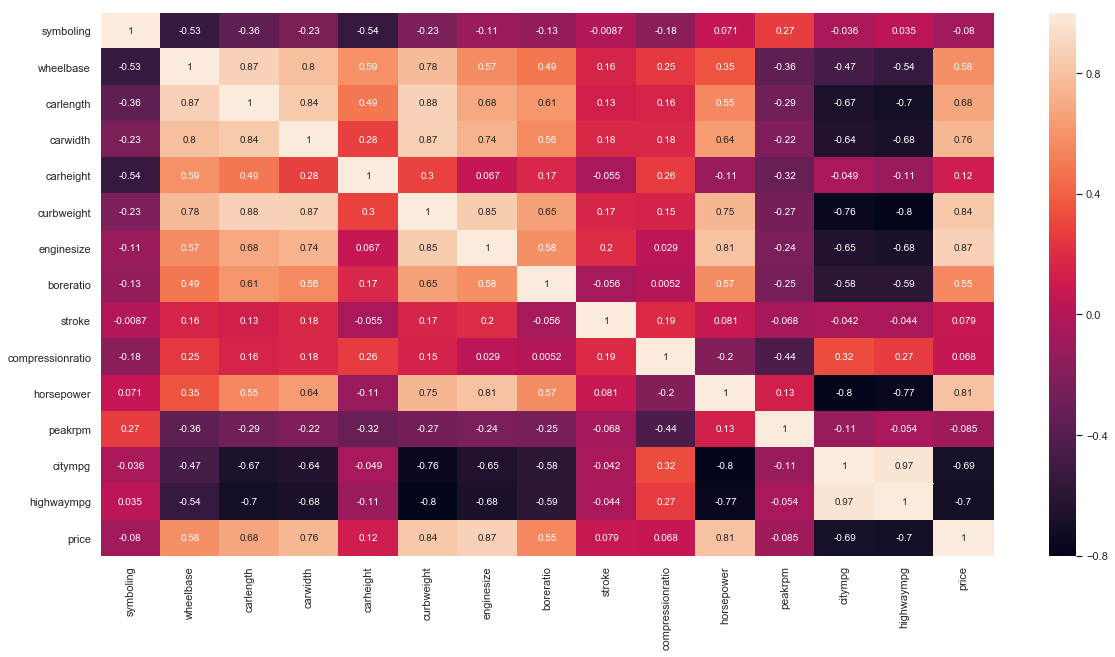

In [640]:
plt.figure(figsize = (20,10))  
sns.heatmap(car_df._get_numeric_data().corr(),annot = True)

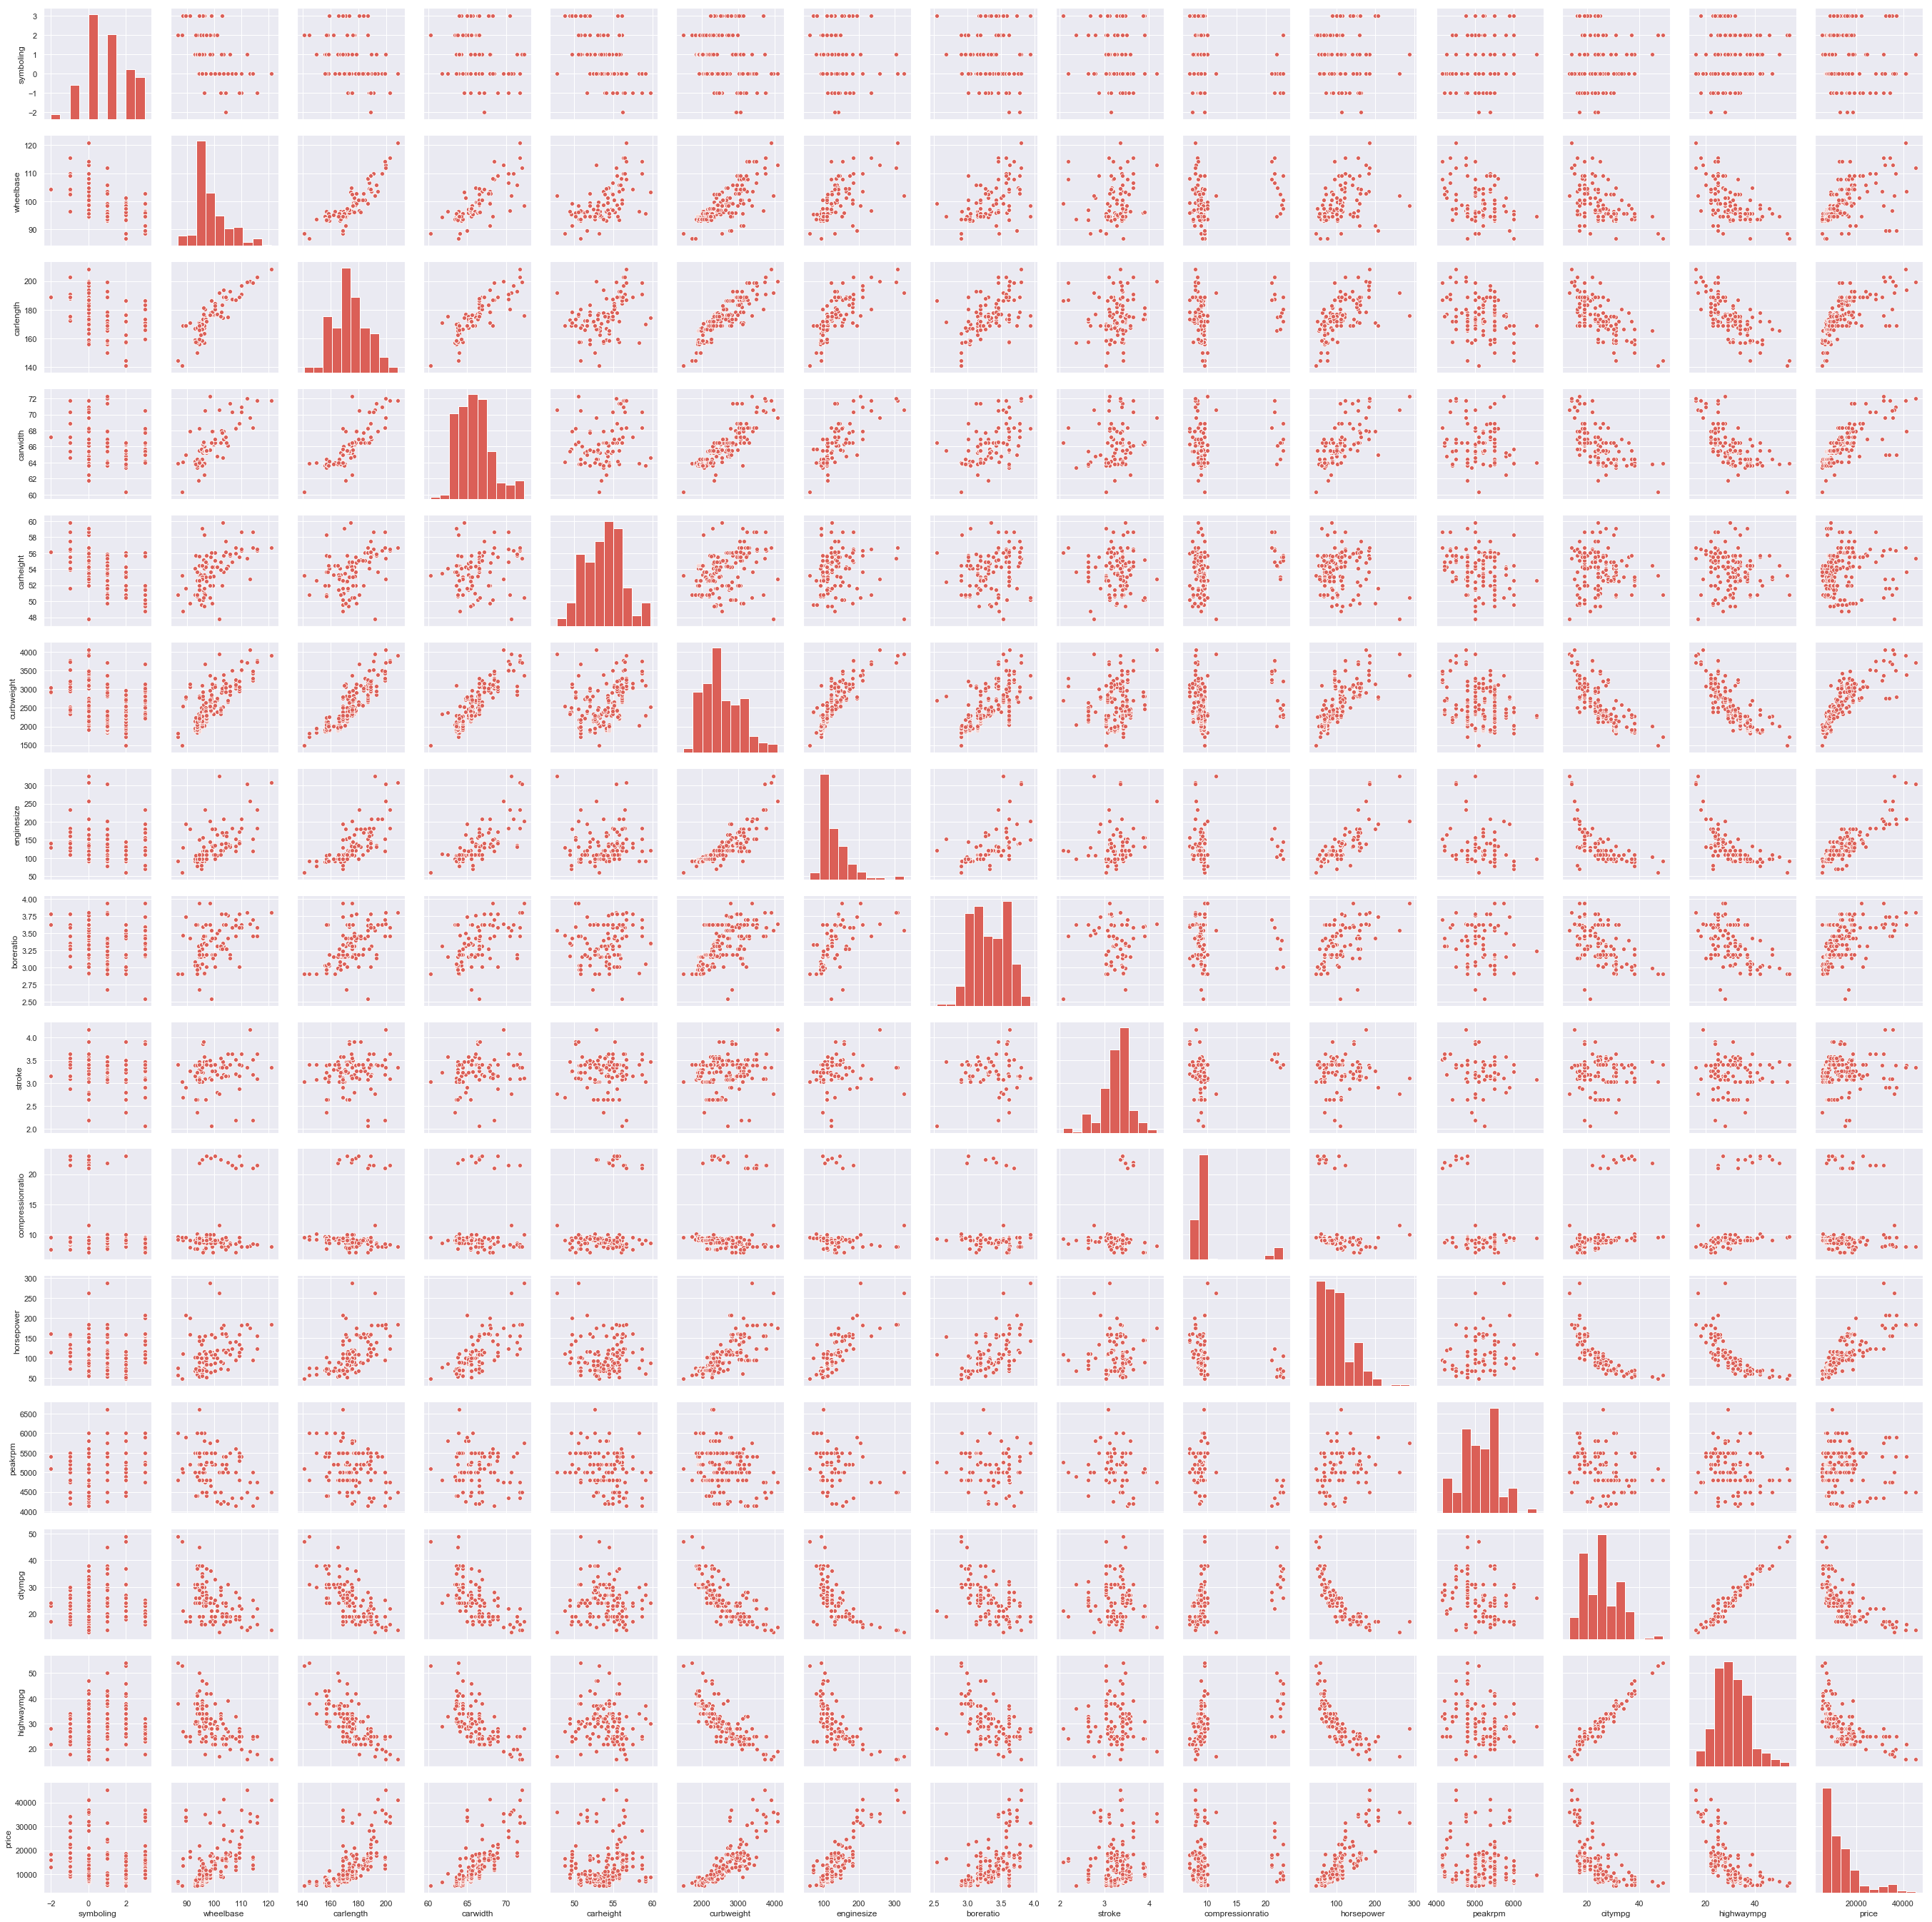

In [641]:
sns.pairplot(car_df)
plt.show()

From the above visualization, we can see variables (non dependent) are correlated with the dependent variable(price)
- wheelbase
- carlength
- carwidth
- curbweight
- enginesize
- boreratio
- horsepower

Finding the mullticollinearity among the non dependent variables by looking to the heat map
- carlength
- carwidth 
- curbweight
- wheelbase 

In [642]:
#There is a high correlation between the wheelbase,carlength,carwidth and curbweight ,hence dropping 3 and keeping one
#car_df.drop(['carwidth','curbweight','wheelbase'], axis =1, inplace = True)
#will retain carlength

Below variables are also highly correlated 97%
- highwaympg
- Citympg 

In [643]:
#There is a high correlation between the highwaympg and Citympg ,hence dropping 1 and keeping one
#car_df.drop(['citympg'], axis =1, inplace = True)
#will retain highwaympg

Below variables are also highly correlated 84%
- carlength
- carwidth 

### Draw Categorical Variable Count and check which feature is predominant in US market

In [644]:
categorical_columns=list(car_df.columns[car_df.dtypes == 'object'])
categorical_columns

['CarCompany',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

Clearly Toyata captured the US market

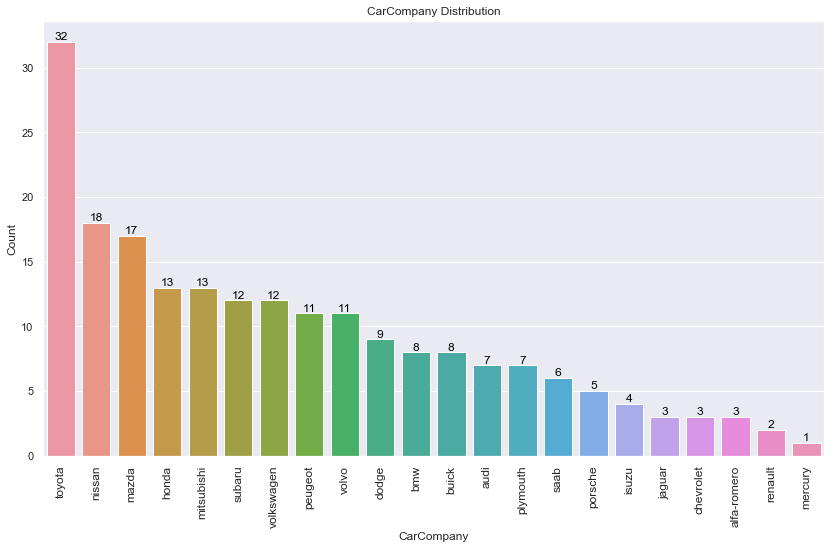

In [645]:
draw_categorical(column_name='CarCompany',title='CarCompany Distribution',df=car_df)

People Prefer Gas Vehicle more than the Diesel

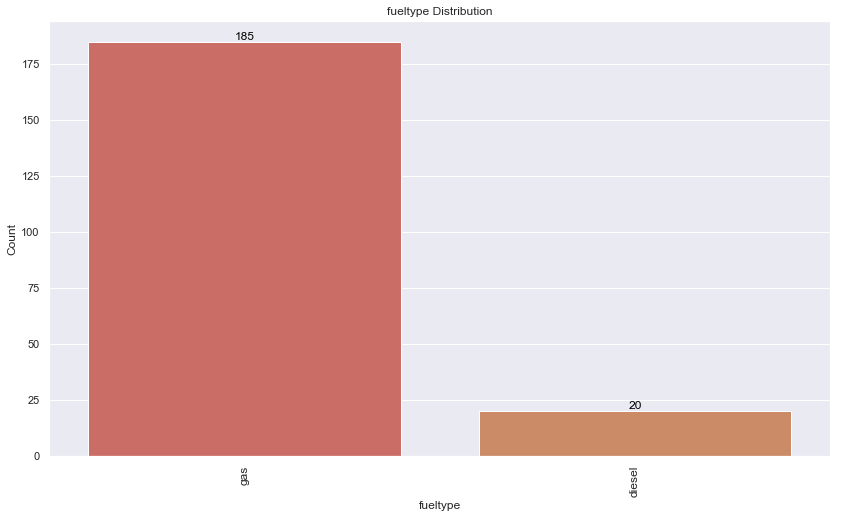

In [646]:
draw_categorical(column_name='fueltype',title='fueltype Distribution',df=car_df)

STD Aspiration predominates

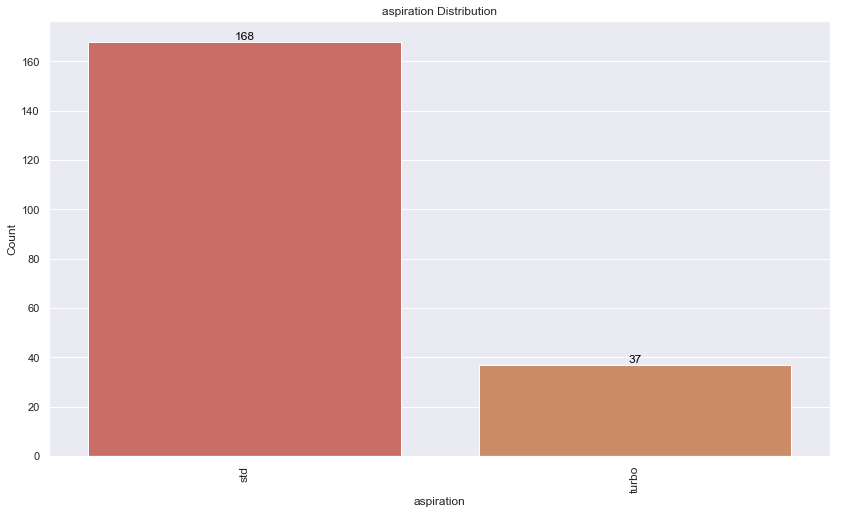

In [647]:
draw_categorical(column_name='aspiration',title='aspiration Distribution',df=car_df)

Sedan & Hachback predominates

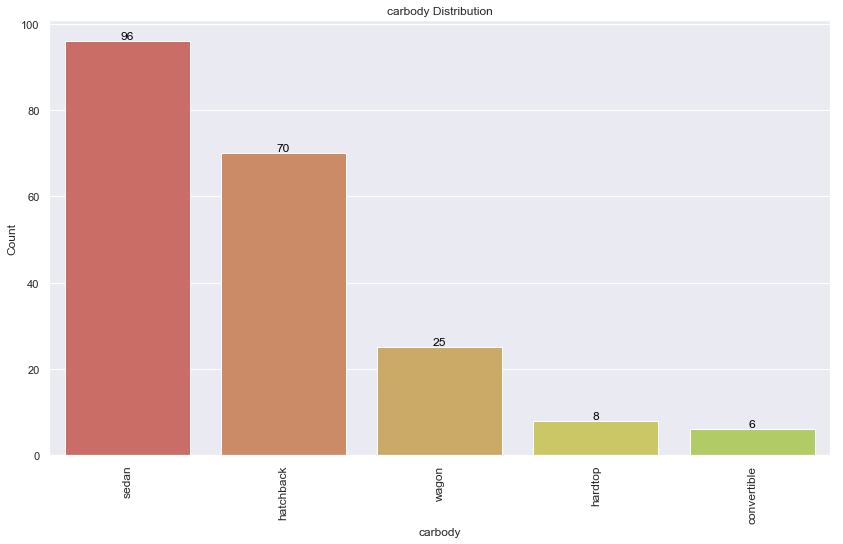

In [648]:
draw_categorical(column_name='carbody',title='carbody Distribution',df=car_df)

People Prefer FWD drive wheel more than RWD

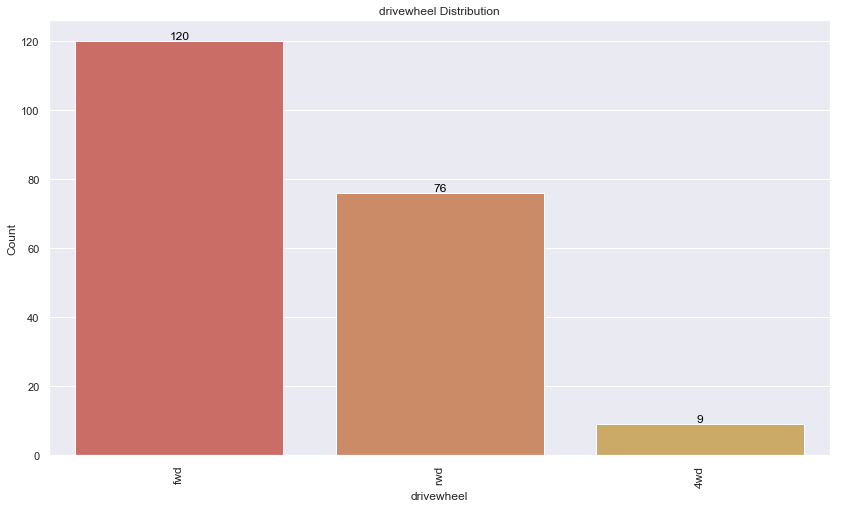

In [649]:
draw_categorical(column_name='drivewheel',title='drivewheel Distribution',df=car_df)

No Doubt Front Engine location are made more 

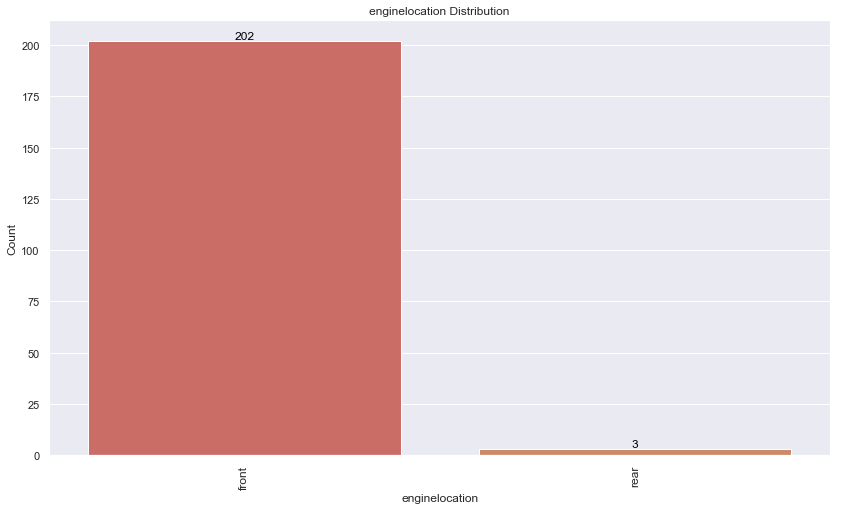

In [650]:
draw_categorical(column_name='enginelocation',title='enginelocation Distribution',df=car_df)

DHC engine vehicle are predominat 

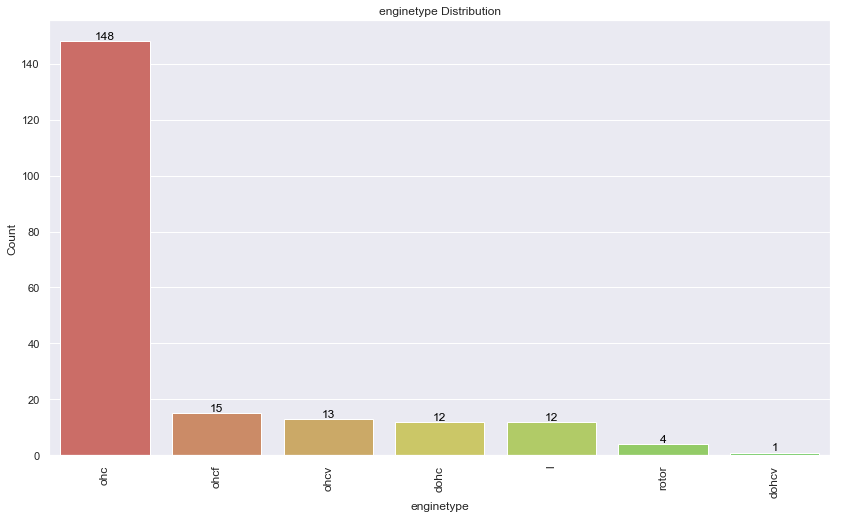

In [651]:
draw_categorical(column_name='enginetype',title='enginetype Distribution',df=car_df)

MPFI fuelSystem cars are produced more followed by 2bbl

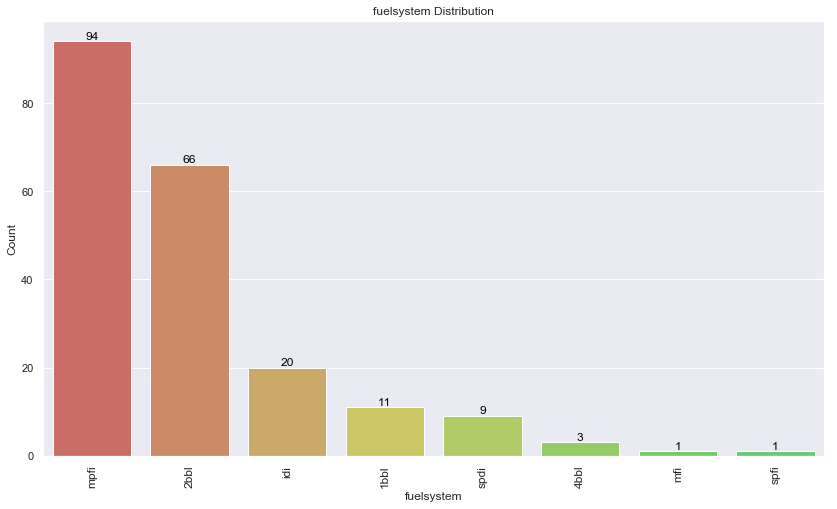

In [652]:
draw_categorical(column_name='fuelsystem',title='fuelsystem Distribution',df=car_df)

Car Company has definelty affected the car prices

In [653]:
car_df['price'].mean()

13276.710570731706

Jaguar buick Porshe bmw vovl has car prices above average car prices in across all the companies

In [654]:
car_df.groupby('CarCompany').price.mean().sort_values(ascending=False).head()

CarCompany
jaguar     34600.000000
buick      33647.000000
porsche    31400.500000
bmw        26118.750000
volvo      18063.181818
Name: price, dtype: float64

In [655]:
continous_variables = list(car_df.columns[car_df.dtypes != 'object'])
continous_variables

['symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg',
 'price']

In [656]:
#draw_continous_plot(column_name='wheelbase',title='wheelbase Distribution',df=car_df)

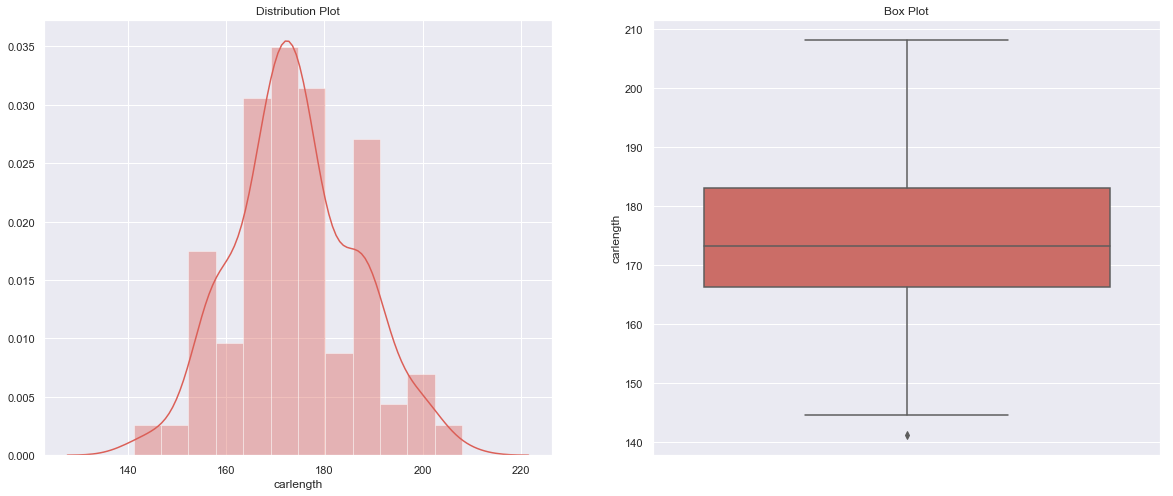

In [657]:
draw_continous_plot(column_name='carlength',title='carlength Distribution',df=car_df)

In [658]:
#draw_continous_plot(column_name='carwidth',title='carwidth Distribution',df=car_df)

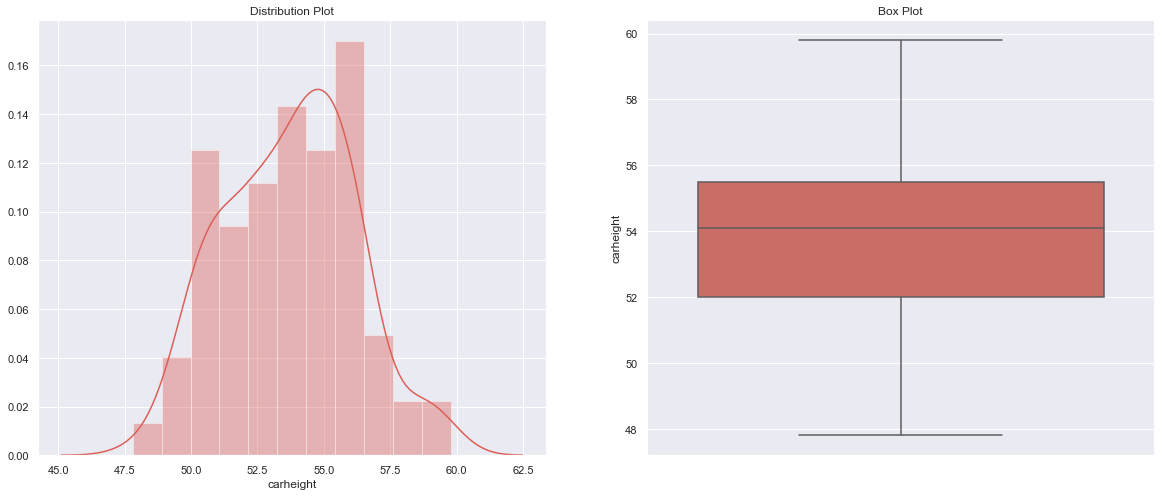

In [659]:
draw_continous_plot(column_name='carheight',title='carheight Distribution',df=car_df)

In [660]:
#draw_continous_plot(column_name='curbweight',title='curbweight Distribution',df=car_df)

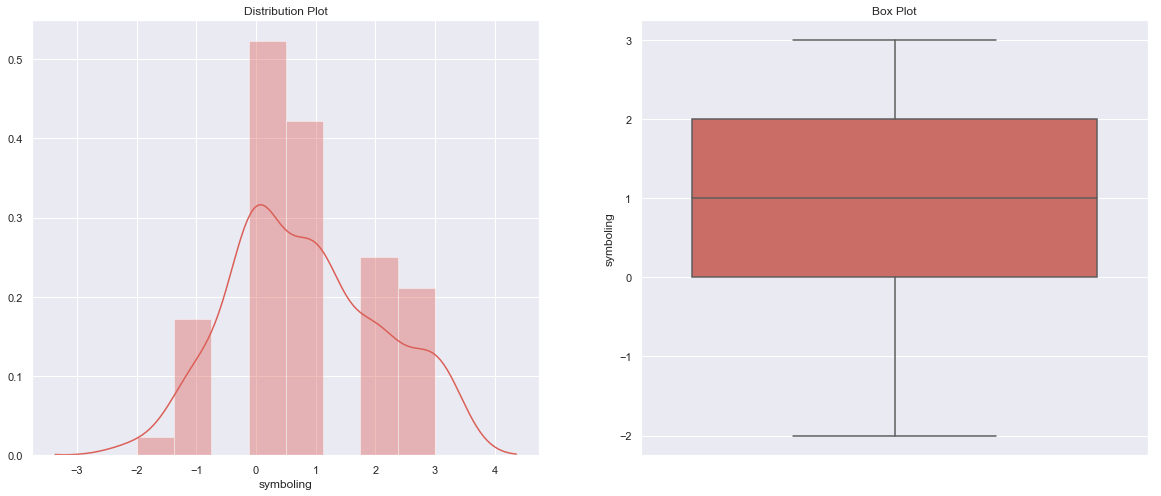

In [661]:
draw_continous_plot(column_name='symboling',title='symboling Distribution',df=car_df)

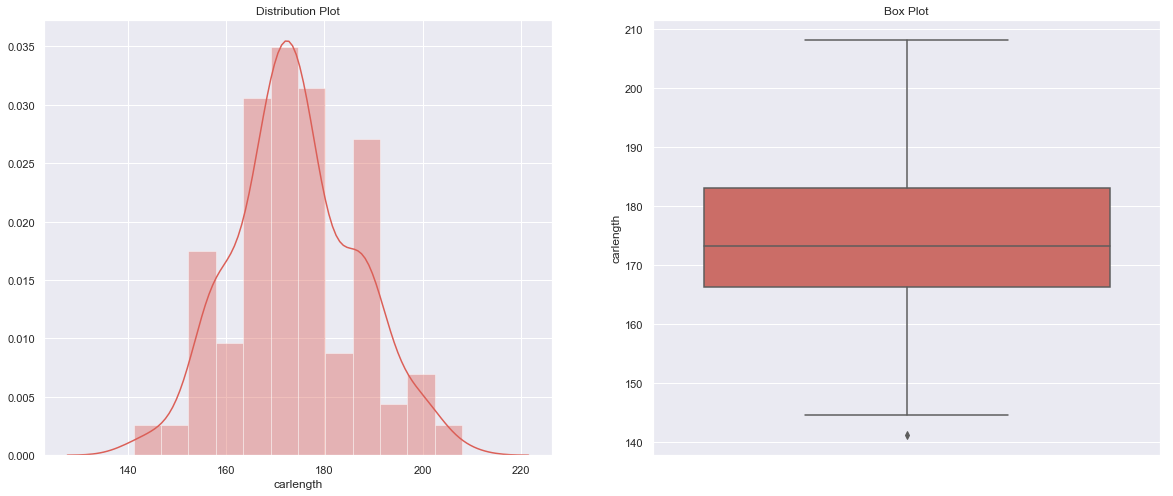

In [662]:
draw_continous_plot(column_name='carlength',title='carlength Distribution',df=car_df)

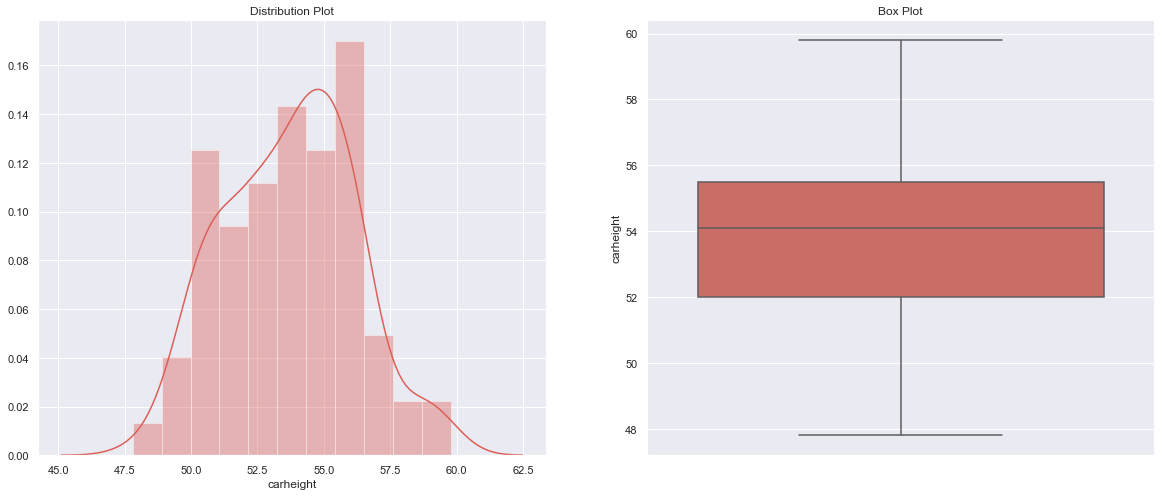

In [663]:
draw_continous_plot(column_name='carheight',title='carheight Distribution',df=car_df)

Engine Size has Outlier 

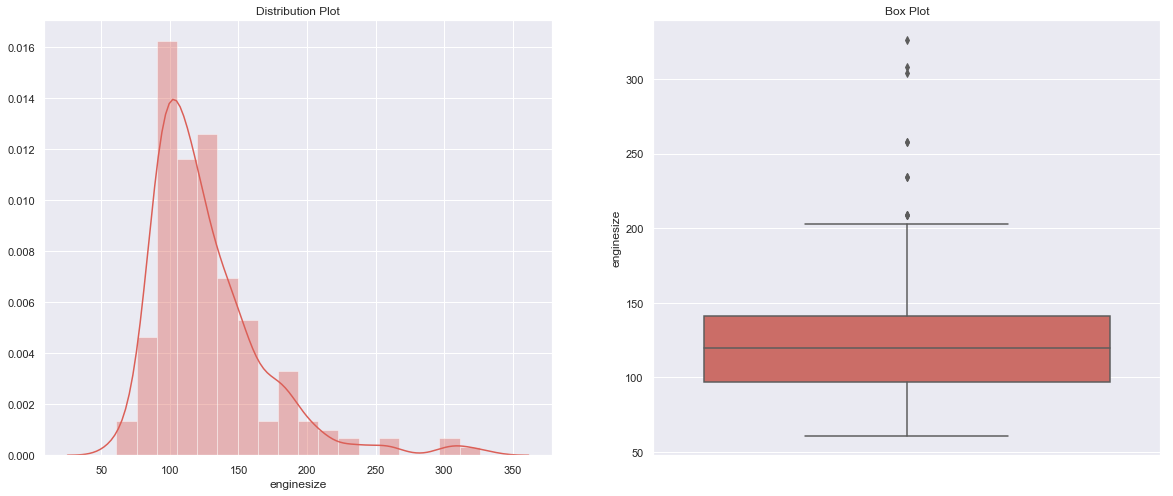

In [664]:
draw_continous_plot(column_name='enginesize',title='enginesize Distribution',df=car_df)

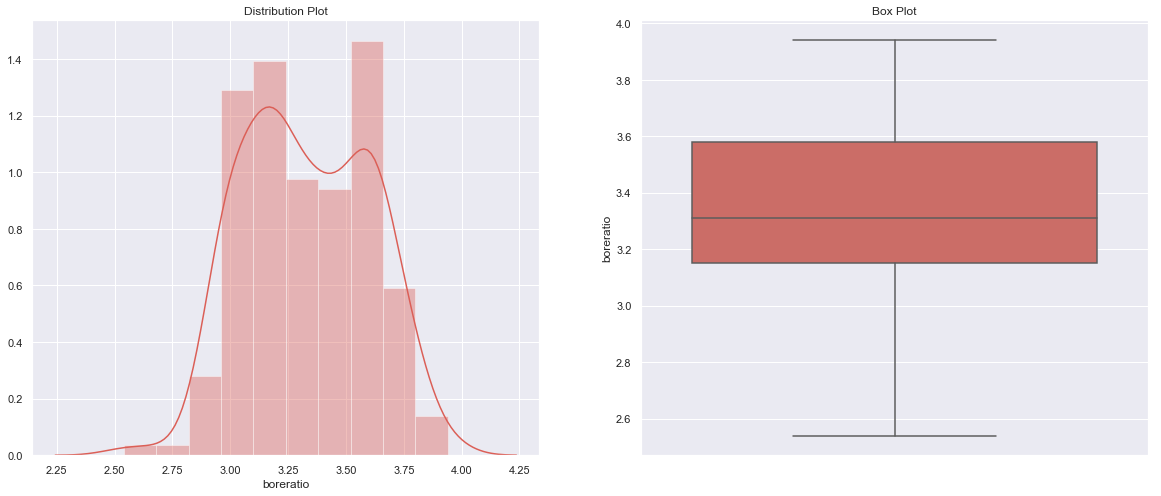

In [665]:
draw_continous_plot(column_name='boreratio',title='boreratio Distribution',df=car_df)

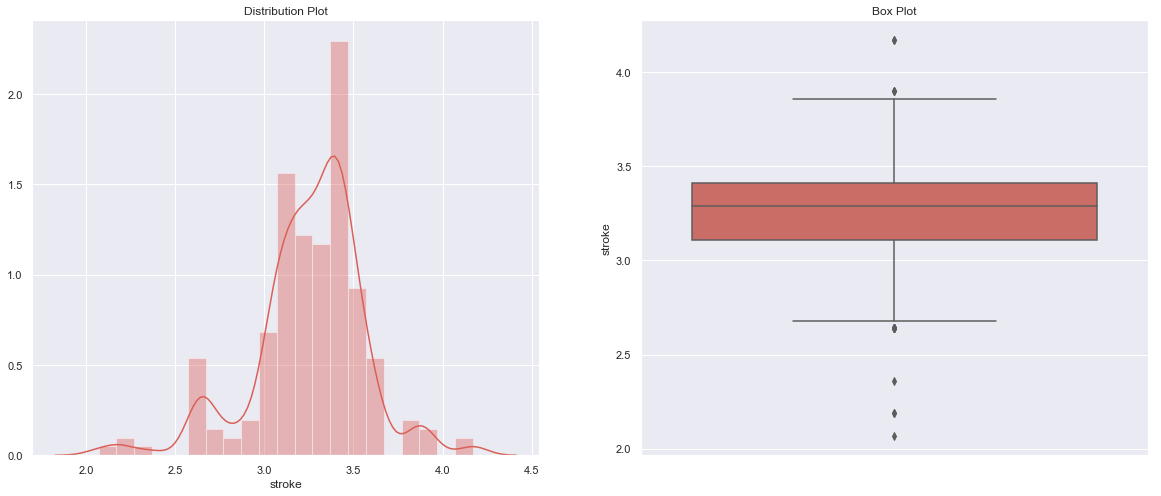

In [666]:
draw_continous_plot(column_name='stroke',title='stroke Distribution',df=car_df)

CompressionRatio has outliers

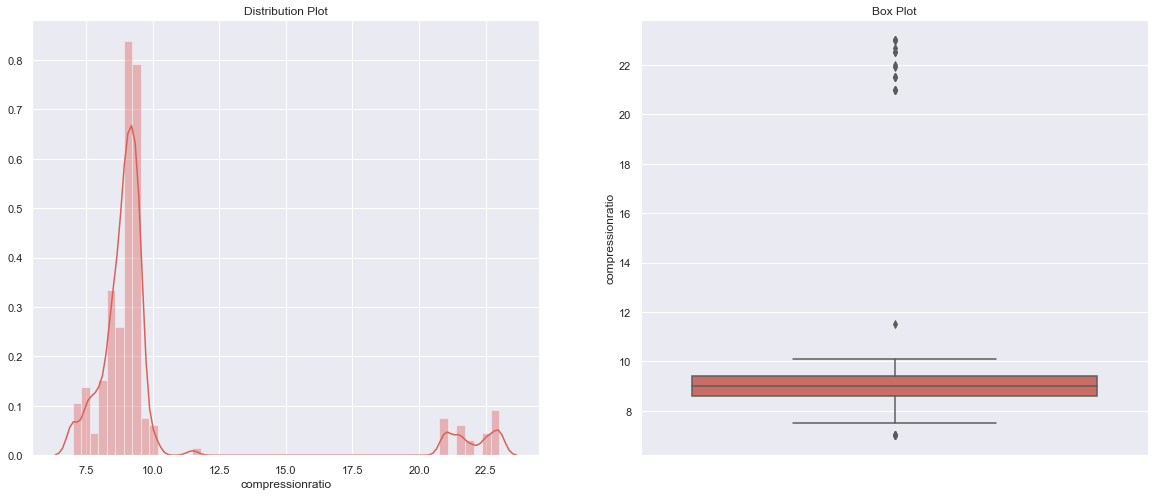

In [667]:
draw_continous_plot(column_name='compressionratio',title='compressionratio Distribution',df=car_df)

Hourse Power have outliers

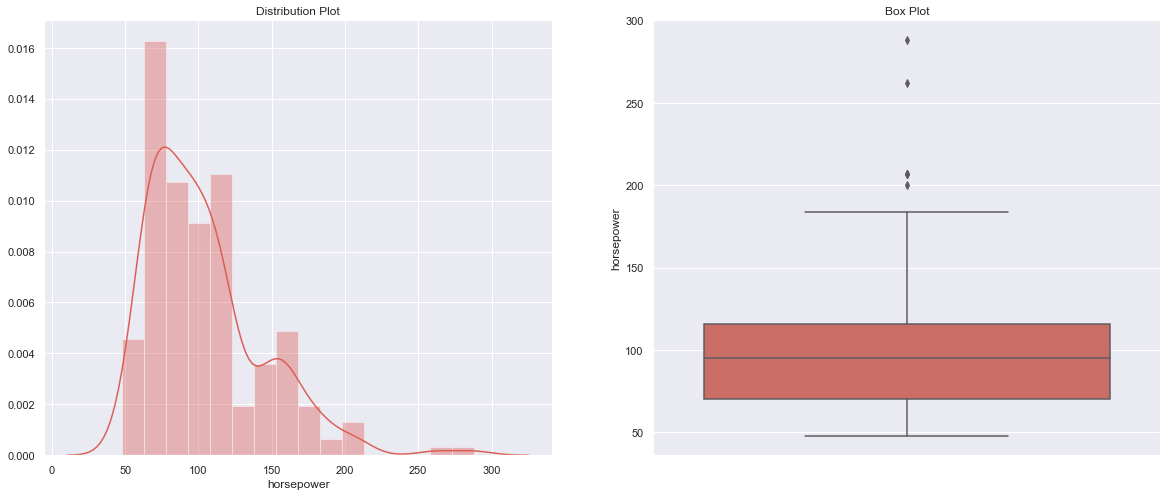

In [668]:
draw_continous_plot(column_name='horsepower',title='horsepower Distribution',df=car_df)

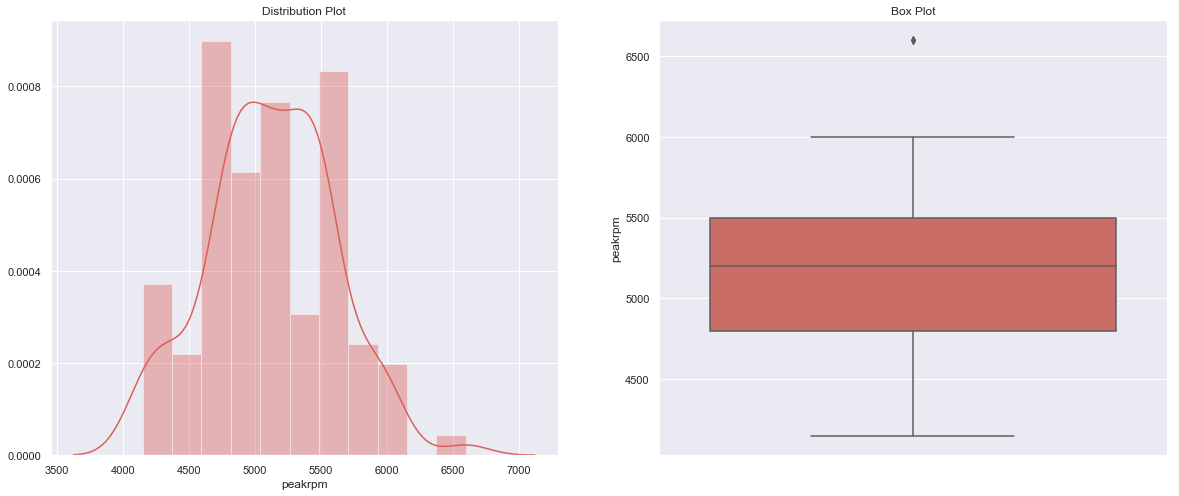

In [669]:
draw_continous_plot(column_name='peakrpm',title='peakrpm Distribution',df=car_df)

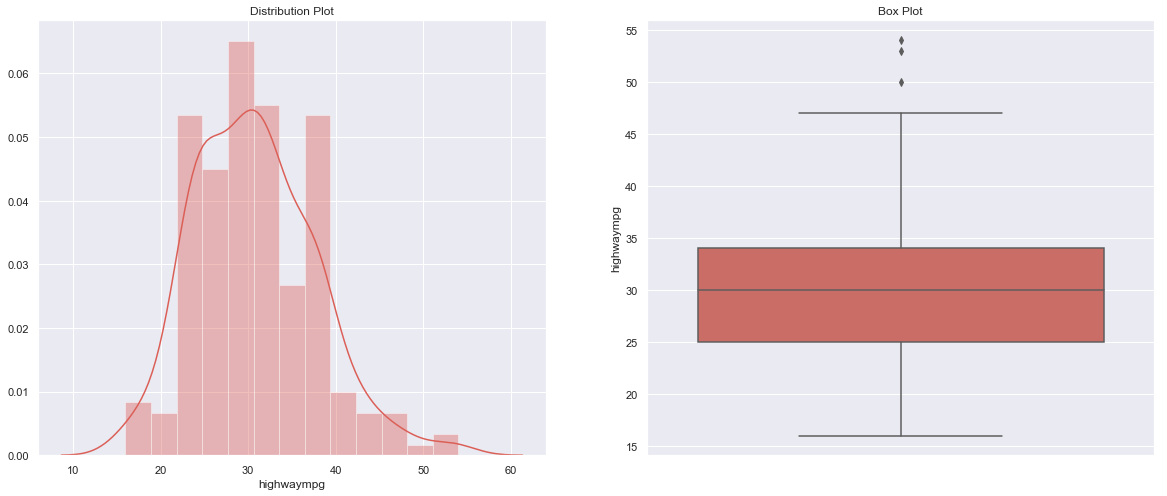

In [670]:
draw_continous_plot(column_name='highwaympg',title='highwaympg Distribution',df=car_df)

Price is also having outliers

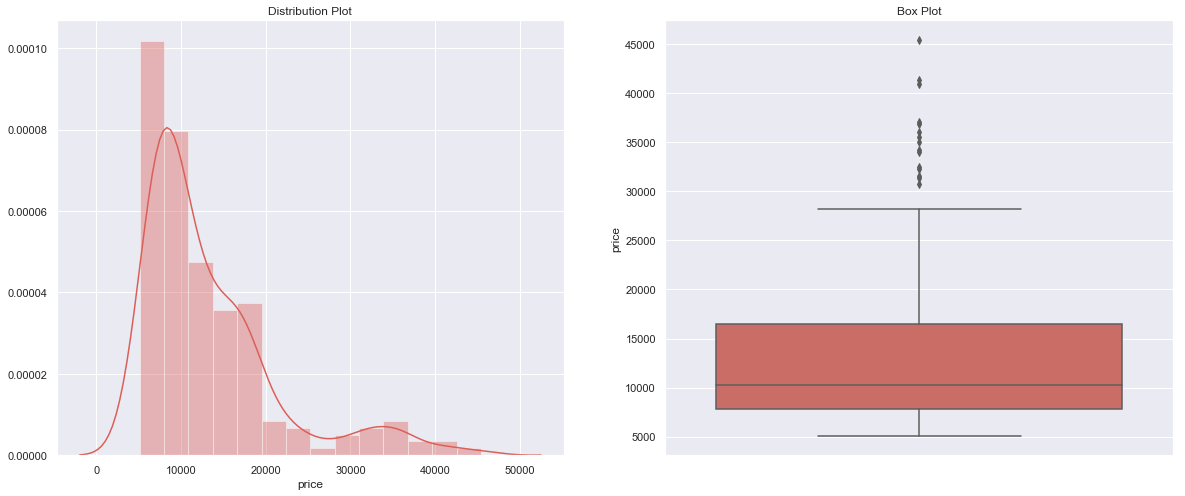

In [671]:
draw_continous_plot(column_name='price',title='price Distribution',df=car_df)

Treating outliers with the 96 percentile value for EngineSize ,CompressionRatio and Hourse Power

In [672]:
car_df[['horsepower','compressionratio','enginesize']].quantile([0.01,0.90,.96])

horsepower  compressionratio  enginesize
0.01       52.12              7.00        70.0
0.90      160.00             10.94       181.0
0.96      182.00             22.42       209.0

In [673]:
# Outilers in price of cars
car_df['horsepower'][np.abs(car_df['horsepower'] > 182.00)]= 182.00

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [674]:
car_df['enginesize'][np.abs(car_df['enginesize'] > 209.00)]= 209.00

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [675]:
car_df['compressionratio'][np.abs(car_df['compressionratio'] > 10.94)]= 10.94

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Remove outlier of price DF 

In [676]:
car_df= car_df[np.abs(car_df.price-car_df.price.mean()) <= (3*car_df.price.std())]

In [677]:
car_df.shape

(202, 25)

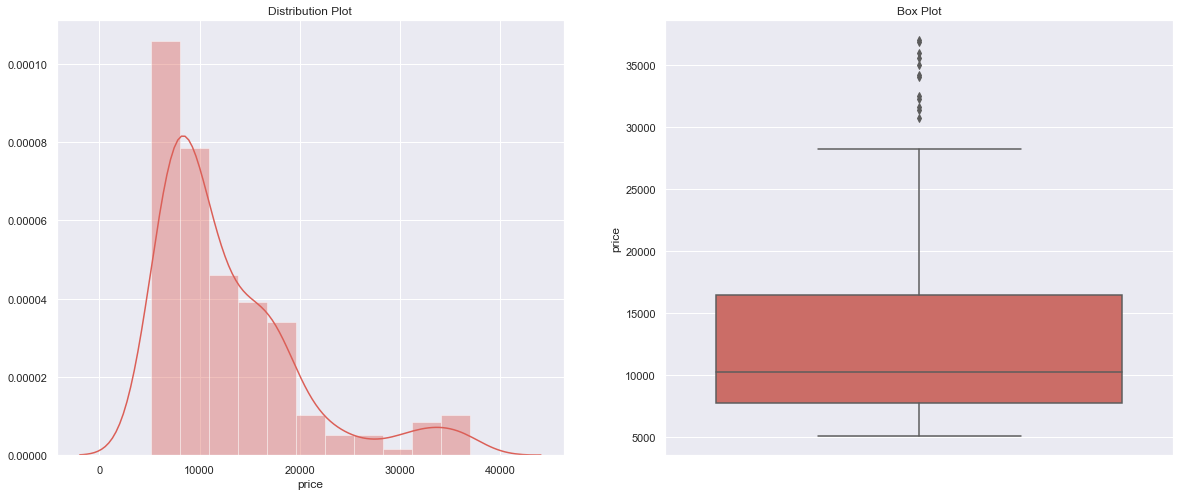

In [678]:
draw_continous_plot(column_name='price',title='price Distribution',df=car_df)

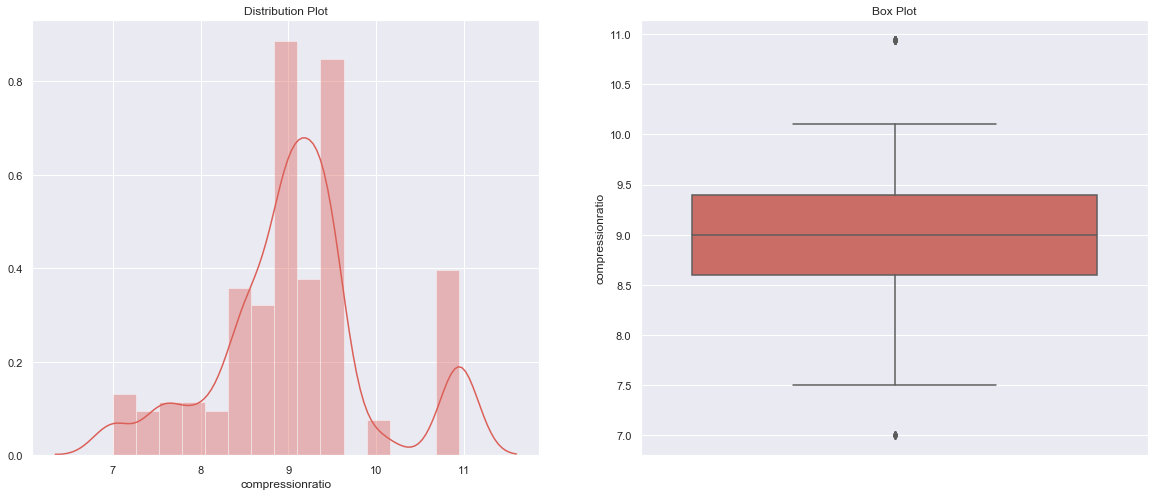

In [679]:
draw_continous_plot(column_name='compressionratio',title='compressionratio Distribution',df=car_df)

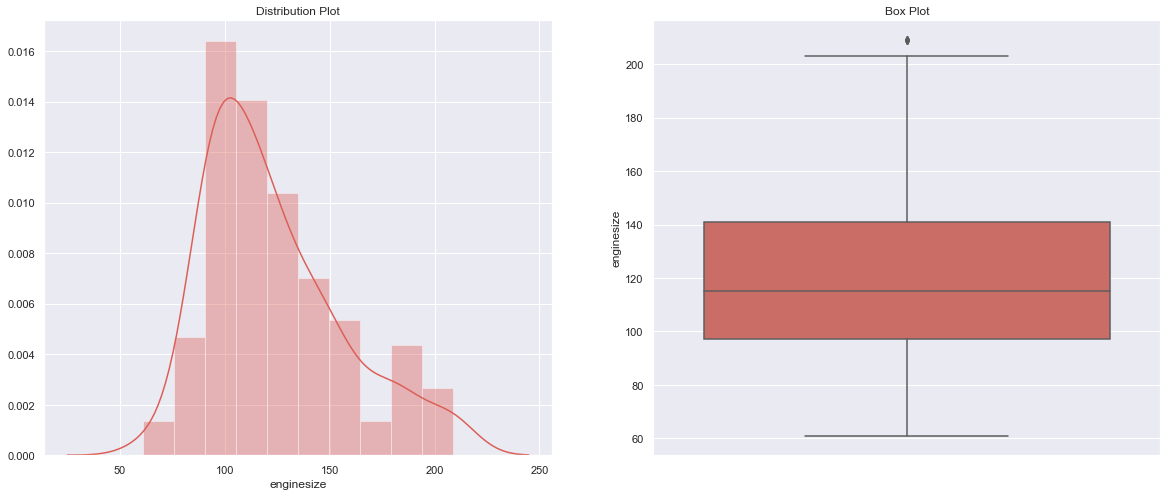

In [680]:
draw_continous_plot(column_name='enginesize',title='enginesize Distribution',df=car_df)

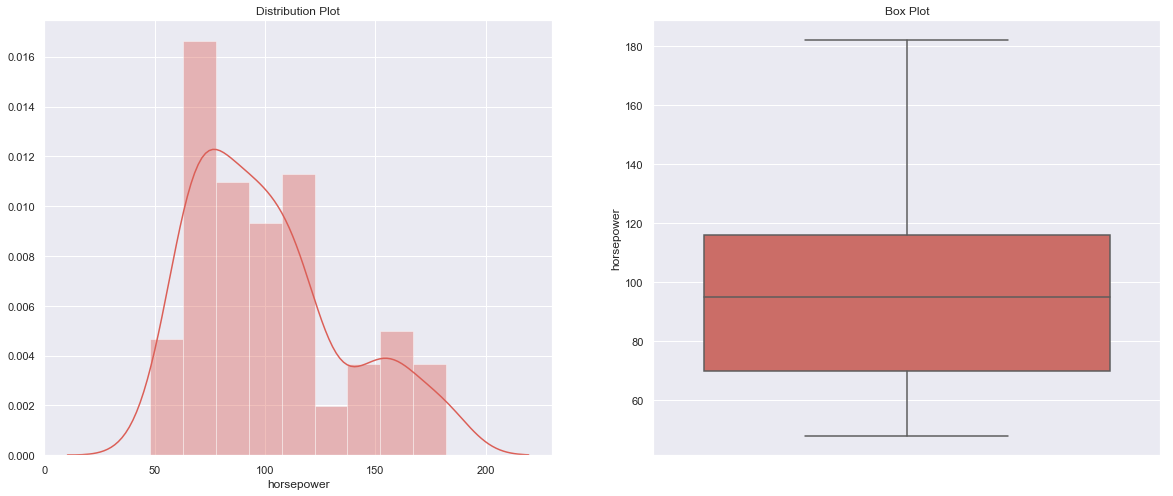

In [681]:
draw_continous_plot(column_name='horsepower',title='horsepower Distribution',df=car_df)

In [682]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202 entries, 0 to 204
Data columns (total 25 columns):
symboling           202 non-null int64
CarCompany          202 non-null object
fueltype            202 non-null object
aspiration          202 non-null object
doornumber          202 non-null object
carbody             202 non-null object
drivewheel          202 non-null object
enginelocation      202 non-null object
wheelbase           202 non-null float64
carlength           202 non-null float64
carwidth            202 non-null float64
carheight           202 non-null float64
curbweight          202 non-null int64
enginetype          202 non-null object
cylindernumber      202 non-null object
enginesize          202 non-null int64
fuelsystem          202 non-null object
boreratio           202 non-null float64
stroke              202 non-null float64
compressionratio    202 non-null float64
horsepower          202 non-null int64
peakrpm             202 non-null int64
citympg           

### Dealing with Categorical variables
#### Covert the characters to numerical values for column with distinct value as 2
- FuelType 1(Gas) 0(Diesel)
- Aspiration 1(Std) 0(Turbo)
- DoorNumber 2(two) 4(Four)
- EngineLocation 1(front) 0(rear)
- Cylindernumber 2(two),3(three),4(four),5(five),6(six),7(seven),8(eight),12(twelve)

In [683]:
#Fuel Type ,Only two distinct values ,hence convert them to numbers
car_df['fueltype']=car_df['fueltype'].map({'gas':1,'diesel':0})

In [684]:
#Aspiration has two distinct values ,hence convert them to numbers
car_df['aspiration']=car_df['aspiration'].map({'std':1,'turbo':0})

In [685]:
#doornumber has two distinct values ,hence convert them to numbers
car_df['doornumber']=car_df['doornumber'].map({'two':0,'four':1})

In [686]:
#enginelocation has two distinct values ,hence convert them to numbers
car_df['enginelocation']=car_df['enginelocation'].map({'front':1,'rear':0})

In [687]:
car_df.head()

symboling   CarCompany  fueltype  aspiration  doornumber      carbody  \
0          3  alfa-romero         1           1           0  convertible   
1          3  alfa-romero         1           1           0  convertible   
2          1  alfa-romero         1           1           0    hatchback   
3          2         audi         1           1           1        sedan   
4          2         audi         1           1           1        sedan   

  drivewheel  enginelocation  wheelbase  carlength   ...     enginesize  \
0        rwd               1       88.6      168.8   ...            130   
1        rwd               1       88.6      168.8   ...            130   
2        rwd               1       94.5      171.2   ...            152   
3        fwd               1       99.8      176.6   ...            109   
4        4wd               1       99.4      176.6   ...            136   

   fuelsystem  boreratio stroke compressionratio  horsepower peakrpm  citympg  \
0        mpfi       3.47   2.68              9.0         111    5000       21   
1        mpfi       3.47   2.68              9.0         111    5000       21   
2        mpfi       2.68   3.47              9.0         154    5000       19   
3        mpfi       3.19   3.40             10.0         102    5500       24   
4        mpfi       3.19   3.40              8.0         115    5500       18   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  

[5 rows x 25 columns]

In [688]:
#check the cylinernumber ,convert them to numbers
print(car_df['cylindernumber'].unique())
car_df.cylindernumber.replace(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight']
                        , [4, 6, 5, 3, 12, 2, 8 ], inplace=True)
print(car_df['cylindernumber'].unique())

['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']
[ 4  6  5  3 12  2  8]


In [689]:
car_df['highwaympg/citympg']=car_df['highwaympg']/car_df['citympg']

In [690]:
car_df['carlength/carwidth']=car_df['carlength']/car_df['carwidth']

In [691]:
car_df['carlength/curbweight']=car_df['carlength']/car_df['curbweight']

In [692]:
car_df['carlength/wheelbase']=car_df['carlength']/car_df['wheelbase']

In [693]:
car_df.drop(['carlength','carwidth','highwaympg','citympg','wheelbase','curbweight'],axis=1,inplace=True)

In [694]:
car_df.price.describe()

count      202.000000
mean     12841.834985
std       7192.112132
min       5118.000000
25%       7778.250000
50%      10221.500000
75%      16482.500000
max      37028.000000
Name: price, dtype: float64

In [695]:
# Loan Amount ,looking to the above data 
car_segment_bin = [0, 10000, 20000, 40000]
car_segment_slot = ['lowline', 'midline', 'highline']
car_df['car_segment_bin'] = pd.cut(car_df['price'], car_segment_bin, labels=car_segment_slot)

In [696]:
car_df.head()

symboling   CarCompany  fueltype  aspiration  doornumber      carbody  \
0          3  alfa-romero         1           1           0  convertible   
1          3  alfa-romero         1           1           0  convertible   
2          1  alfa-romero         1           1           0    hatchback   
3          2         audi         1           1           1        sedan   
4          2         audi         1           1           1        sedan   

  drivewheel  enginelocation  carheight enginetype       ...         stroke  \
0        rwd               1       48.8       dohc       ...           2.68   
1        rwd               1       48.8       dohc       ...           2.68   
2        rwd               1       52.4       ohcv       ...           3.47   
3        fwd               1       54.3        ohc       ...           3.40   
4        4wd               1       54.3        ohc       ...           3.40   

   compressionratio horsepower  peakrpm    price  highwaympg/citympg  \
0               9.0        111     5000  13495.0            1.285714   
1               9.0        111     5000  16500.0            1.285714   
2               9.0        154     5000  16500.0            1.368421   
3              10.0        102     5500  13950.0            1.250000   
4               8.0        115     5500  17450.0            1.222222   

   carlength/carwidth  carlength/curbweight  carlength/wheelbase  \
0            2.633385              0.066248             1.905192   
1            2.633385              0.066248             1.905192   
2            2.613740              0.060645             1.811640   
3            2.667674              0.075567             1.769539   
4            2.659639              0.062535             1.776660   

   car_segment_bin  
0          midline  
1          midline  
2          midline  
3          midline  
4          midline  

[5 rows x 24 columns]

### Dummy Variables
- carbody
- CarCompany
- driveWheel
- EngineType
- FuelType
- cylindernumber 
- car_segment_bin

In [697]:
# Get the dummy variables for the feature 'carbody' and store it in a new variable - 'body'
# we don't need five columns. We can drop the `convertible` column, as the type of body can be identified with just the four columns where — 
body = pd.get_dummies(car_df['carbody'], drop_first = True,prefix="carbody_")

# Add the results to the original Car dataframe
car_df = pd.concat([car_df, body], axis = 1)

#drop the original column 
car_df.drop(['carbody'], axis =1, inplace = True)
car_df.head()

symboling   CarCompany  fueltype  aspiration  doornumber drivewheel  \
0          3  alfa-romero         1           1           0        rwd   
1          3  alfa-romero         1           1           0        rwd   
2          1  alfa-romero         1           1           0        rwd   
3          2         audi         1           1           1        fwd   
4          2         audi         1           1           1        4wd   

   enginelocation  carheight enginetype  cylindernumber       ...        \
0               1       48.8       dohc               4       ...         
1               1       48.8       dohc               4       ...         
2               1       52.4       ohcv               6       ...         
3               1       54.3        ohc               4       ...         
4               1       54.3        ohc               5       ...         

     price highwaympg/citympg  carlength/carwidth  carlength/curbweight  \
0  13495.0           1.285714            2.633385              0.066248   
1  16500.0           1.285714            2.633385              0.066248   
2  16500.0           1.368421            2.613740              0.060645   
3  13950.0           1.250000            2.667674              0.075567   
4  17450.0           1.222222            2.659639              0.062535   

   carlength/wheelbase  car_segment_bin  carbody__hardtop  carbody__hatchback  \
0             1.905192          midline                 0                   0   
1             1.905192          midline                 0                   0   
2             1.811640          midline                 0                   1   
3             1.769539          midline                 0                   0   
4             1.776660          midline                 0                   0   

   carbody__sedan  carbody__wagon  
0               0               0  
1               0               0  
2               0               0  
3               1               0  
4               1               0  

[5 rows x 27 columns]

In [698]:
#dealing with CarCompany
companies = pd.get_dummies(car_df['CarCompany'], drop_first = True,prefix="CarCompany_")

# Add the results to the original Car dataframe
car_df = pd.concat([car_df, companies], axis = 1)

#drop the original column 
car_df.drop(['CarCompany'], axis =1, inplace = True)
car_df.head()

symboling  fueltype  aspiration  doornumber drivewheel  enginelocation  \
0          3         1           1           0        rwd               1   
1          3         1           1           0        rwd               1   
2          1         1           1           0        rwd               1   
3          2         1           1           1        fwd               1   
4          2         1           1           1        4wd               1   

   carheight enginetype  cylindernumber  enginesize        ...          \
0       48.8       dohc               4         130        ...           
1       48.8       dohc               4         130        ...           
2       52.4       ohcv               6         152        ...           
3       54.3        ohc               4         109        ...           
4       54.3        ohc               5         136        ...           

  CarCompany__nissan  CarCompany__peugeot  CarCompany__plymouth  \
0                  0                    0                     0   
1                  0                    0                     0   
2                  0                    0                     0   
3                  0                    0                     0   
4                  0                    0                     0   

   CarCompany__porsche  CarCompany__renault  CarCompany__saab  \
0                    0                    0                 0   
1                    0                    0                 0   
2                    0                    0                 0   
3                    0                    0                 0   
4                    0                    0                 0   

   CarCompany__subaru  CarCompany__toyota  CarCompany__volkswagen  \
0                   0                   0                       0   
1                   0                   0                       0   
2                   0                   0                       0   
3                   0                   0                       0   
4                   0                   0                       0   

   CarCompany__volvo  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 47 columns]

In [699]:
#dealing with drivewheel
drive_wheel = pd.get_dummies(car_df['drivewheel'], drop_first = True,prefix="drivewheel_")

# Add the results to the original Car dataframe
car_df = pd.concat([car_df, drive_wheel], axis = 1)

#drop the original column 
car_df.drop(['drivewheel'], axis =1, inplace = True)
car_df.head()

symboling  fueltype  aspiration  doornumber  enginelocation  carheight  \
0          3         1           1           0               1       48.8   
1          3         1           1           0               1       48.8   
2          1         1           1           0               1       52.4   
3          2         1           1           1               1       54.3   
4          2         1           1           1               1       54.3   

  enginetype  cylindernumber  enginesize fuelsystem       ...         \
0       dohc               4         130       mpfi       ...          
1       dohc               4         130       mpfi       ...          
2       ohcv               6         152       mpfi       ...          
3        ohc               4         109       mpfi       ...          
4        ohc               5         136       mpfi       ...          

   CarCompany__plymouth  CarCompany__porsche  CarCompany__renault  \
0                     0                    0                    0   
1                     0                    0                    0   
2                     0                    0                    0   
3                     0                    0                    0   
4                     0                    0                    0   

   CarCompany__saab  CarCompany__subaru  CarCompany__toyota  \
0                 0                   0                   0   
1                 0                   0                   0   
2                 0                   0                   0   
3                 0                   0                   0   
4                 0                   0                   0   

   CarCompany__volkswagen  CarCompany__volvo  drivewheel__fwd  drivewheel__rwd  
0                       0                  0                0                1  
1                       0                  0                0                1  
2                       0                  0                0                1  
3                       0                  0                1                0  
4                       0                  0                0                0  

[5 rows x 48 columns]

In [700]:
#dealing with enginetype
engine_type = pd.get_dummies(car_df['enginetype'], drop_first = True,prefix="enginetype_")

# Add the results to the original Car dataframe
car_df = pd.concat([car_df, engine_type], axis = 1)

#drop the original column 
car_df.drop(['enginetype'], axis =1, inplace = True)
car_df.head()

symboling  fueltype  aspiration  doornumber  enginelocation  carheight  \
0          3         1           1           0               1       48.8   
1          3         1           1           0               1       48.8   
2          1         1           1           0               1       52.4   
3          2         1           1           1               1       54.3   
4          2         1           1           1               1       54.3   

   cylindernumber  enginesize fuelsystem  boreratio        ...         \
0               4         130       mpfi       3.47        ...          
1               4         130       mpfi       3.47        ...          
2               6         152       mpfi       2.68        ...          
3               4         109       mpfi       3.19        ...          
4               5         136       mpfi       3.19        ...          

   CarCompany__volkswagen  CarCompany__volvo  drivewheel__fwd  \
0                       0                  0                0   
1                       0                  0                0   
2                       0                  0                0   
3                       0                  0                1   
4                       0                  0                0   

   drivewheel__rwd  enginetype__dohcv  enginetype__l  enginetype__ohc  \
0                1                  0              0                0   
1                1                  0              0                0   
2                1                  0              0                0   
3                0                  0              0                1   
4                0                  0              0                1   

   enginetype__ohcf  enginetype__ohcv enginetype__rotor  
0                 0                 0                 0  
1                 0                 0                 0  
2                 0                 1                 0  
3                 0                 0                 0  
4                 0                 0                 0  

[5 rows x 53 columns]

In [701]:
#dealing with fuelsystem
fuel_system = pd.get_dummies(car_df['fuelsystem'], drop_first = True,prefix="fuelsystem_")

# Add the results to the original Car dataframe
car_df = pd.concat([car_df, fuel_system], axis = 1)

#drop the original column 
car_df.drop(['fuelsystem'], axis =1, inplace = True)
car_df.head()

symboling  fueltype  aspiration  doornumber  enginelocation  carheight  \
0          3         1           1           0               1       48.8   
1          3         1           1           0               1       48.8   
2          1         1           1           0               1       52.4   
3          2         1           1           1               1       54.3   
4          2         1           1           1               1       54.3   

   cylindernumber  enginesize  boreratio  stroke        ...         \
0               4         130       3.47    2.68        ...          
1               4         130       3.47    2.68        ...          
2               6         152       2.68    3.47        ...          
3               4         109       3.19    3.40        ...          
4               5         136       3.19    3.40        ...          

   enginetype__ohcf  enginetype__ohcv  enginetype__rotor  fuelsystem__2bbl  \
0                 0                 0                  0                 0   
1                 0                 0                  0                 0   
2                 0                 1                  0                 0   
3                 0                 0                  0                 0   
4                 0                 0                  0                 0   

   fuelsystem__4bbl  fuelsystem__idi  fuelsystem__mfi  fuelsystem__mpfi  \
0                 0                0                0                 1   
1                 0                0                0                 1   
2                 0                0                0                 1   
3                 0                0                0                 1   
4                 0                0                0                 1   

  fuelsystem__spdi  fuelsystem__spfi  
0                0                 0  
1                0                 0  
2                0                 0  
3                0                 0  
4                0                 0  

[5 rows x 59 columns]

In [702]:
#dealing with cylindernumber
cylinder_number = pd.get_dummies(car_df['cylindernumber'], drop_first = True,prefix="cylindernumber_")

# Add the results to the original Car dataframe
car_df = pd.concat([car_df, cylinder_number], axis = 1)

#drop the original column 
car_df.drop(['cylindernumber'], axis =1, inplace = True)
car_df.head()

symboling  fueltype  aspiration  doornumber  enginelocation  carheight  \
0          3         1           1           0               1       48.8   
1          3         1           1           0               1       48.8   
2          1         1           1           0               1       52.4   
3          2         1           1           1               1       54.3   
4          2         1           1           1               1       54.3   

   enginesize  boreratio  stroke  compressionratio         ...          \
0         130       3.47    2.68               9.0         ...           
1         130       3.47    2.68               9.0         ...           
2         152       2.68    3.47               9.0         ...           
3         109       3.19    3.40              10.0         ...           
4         136       3.19    3.40               8.0         ...           

   fuelsystem__mfi  fuelsystem__mpfi  fuelsystem__spdi  fuelsystem__spfi  \
0                0                 1                 0                 0   
1                0                 1                 0                 0   
2                0                 1                 0                 0   
3                0                 1                 0                 0   
4                0                 1                 0                 0   

   cylindernumber__3  cylindernumber__4  cylindernumber__5 cylindernumber__6  \
0                  0                  1                  0                 0   
1                  0                  1                  0                 0   
2                  0                  0                  0                 1   
3                  0                  1                  0                 0   
4                  0                  0                  1                 0   

   cylindernumber__8  cylindernumber__12  
0                  0                   0  
1                  0                   0  
2                  0                   0  
3                  0                   0  
4                  0                   0  

[5 rows x 64 columns]

In [703]:
# Get the dummy variables for the feature 'carbody' and store it in a new variable - 'body'
# we don't need five columns. We can drop the `convertible` column, as the type of body can be identified with just the four columns where — 
body = pd.get_dummies(car_df['car_segment_bin'], drop_first = True,prefix="car_segment_bin_")

# Add the results to the original Car dataframe
car_df = pd.concat([car_df, body], axis = 1)

#drop the original column 
car_df.drop(['car_segment_bin'], axis =1, inplace = True)
car_df.head()

symboling  fueltype  aspiration  doornumber  enginelocation  carheight  \
0          3         1           1           0               1       48.8   
1          3         1           1           0               1       48.8   
2          1         1           1           0               1       52.4   
3          2         1           1           1               1       54.3   
4          2         1           1           1               1       54.3   

   enginesize  boreratio  stroke  compressionratio            ...              \
0         130       3.47    2.68               9.0            ...               
1         130       3.47    2.68               9.0            ...               
2         152       2.68    3.47               9.0            ...               
3         109       3.19    3.40              10.0            ...               
4         136       3.19    3.40               8.0            ...               

   fuelsystem__spdi  fuelsystem__spfi  cylindernumber__3  cylindernumber__4  \
0                 0                 0                  0                  1   
1                 0                 0                  0                  1   
2                 0                 0                  0                  0   
3                 0                 0                  0                  1   
4                 0                 0                  0                  0   

   cylindernumber__5  cylindernumber__6  cylindernumber__8  \
0                  0                  0                  0   
1                  0                  0                  0   
2                  0                  1                  0   
3                  0                  0                  0   
4                  1                  0                  0   

   cylindernumber__12  car_segment_bin__midline  car_segment_bin__highline  
0                   0                         1                          0  
1                   0                         1                          0  
2                   0                         1                          0  
3                   0                         1                          0  
4                   0                         1                          0  

[5 rows x 65 columns]

In [704]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202 entries, 0 to 204
Data columns (total 65 columns):
symboling                    202 non-null int64
fueltype                     202 non-null int64
aspiration                   202 non-null int64
doornumber                   202 non-null int64
enginelocation               202 non-null int64
carheight                    202 non-null float64
enginesize                   202 non-null int64
boreratio                    202 non-null float64
stroke                       202 non-null float64
compressionratio             202 non-null float64
horsepower                   202 non-null int64
peakrpm                      202 non-null int64
price                        202 non-null float64
highwaympg/citympg           202 non-null float64
carlength/carwidth           202 non-null float64
carlength/curbweight         202 non-null float64
carlength/wheelbase          202 non-null float64
carbody__hardtop             202 non-null uint8
carbody__hatchback

## Splitting the Data into Training and Testing Sets

In [705]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
car_df_train, car_df_test = train_test_split(car_df, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

We will use MinMax scaling.

In [706]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [707]:
car_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, 1 to 8
Data columns (total 65 columns):
symboling                    141 non-null int64
fueltype                     141 non-null int64
aspiration                   141 non-null int64
doornumber                   141 non-null int64
enginelocation               141 non-null int64
carheight                    141 non-null float64
enginesize                   141 non-null int64
boreratio                    141 non-null float64
stroke                       141 non-null float64
compressionratio             141 non-null float64
horsepower                   141 non-null int64
peakrpm                      141 non-null int64
price                        141 non-null float64
highwaympg/citympg           141 non-null float64
carlength/carwidth           141 non-null float64
carlength/curbweight         141 non-null float64
carlength/wheelbase          141 non-null float64
carbody__hardtop             141 non-null uint8
carbody__hatchback  

In [710]:
cols_to_scale = ['symboling','carheight',
         'enginesize', 'boreratio', 'stroke', 'compressionratio','horsepower', 'peakrpm'
                 , 'price'
                ,'highwaympg/citympg','carlength/carwidth','carlength/wheelbase','carlength/curbweight'
                ]


In [713]:
car_df_train[cols_to_scale] = scaler.fit_transform(car_df_train[cols_to_scale])

car_df_train.head()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


symboling  fueltype  aspiration  doornumber  enginelocation  carheight  \
1          1.0         1           1           0               1   0.083333   
165        0.6         1           1           0               1   0.400000   
197        0.2         1           1           1               1   0.808333   
169        0.8         1           1           0               1   0.350000   
190        1.0         1           1           0               1   0.300000   

     enginesize  boreratio    stroke  compressionratio  \
1      0.466216   0.664286  0.290476          0.507614   
165    0.250000   0.500000  0.480952          0.609137   
197    0.540541   0.885714  0.514286          0.634518   
169    0.574324   0.771429  0.680952          0.583756   
190    0.324324   0.464286  0.633333          0.380711   

               ...              fuelsystem__spdi  fuelsystem__spfi  \
1              ...                             0                 0   
165            ...                             0                 0   
197            ...                             0                 0   
169            ...                             0                 0   
190            ...                             0                 0   

     cylindernumber__3  cylindernumber__4  cylindernumber__5  \
1                    0                  1                  0   
165                  0                  1                  0   
197                  0                  1                  0   
169                  0                  1                  0   
190                  0                  1                  0   

     cylindernumber__6  cylindernumber__8  cylindernumber__12  \
1                    0                  0                   0   
165                  0                  0                   0   
197                  0                  0                   0   
169                  0                  0                   0   
190                  0                  0                   0   

     car_segment_bin__midline  car_segment_bin__highline  
1                           1                          0  
165                         0                          0  
197                         1                          0  
169                         0                          0  
190                         0                          0  

[5 rows x 65 columns]

In [714]:
car_df_train.describe()

symboling    fueltype  aspiration  doornumber  enginelocation  \
count  141.000000  141.000000  141.000000  141.000000      141.000000   
mean     0.570213    0.886525    0.794326    0.560284        0.985816   
std      0.246039    0.318304    0.405634    0.498122        0.118672   
min      0.000000    0.000000    0.000000    0.000000        0.000000   
25%      0.400000    1.000000    1.000000    0.000000        1.000000   
50%      0.600000    1.000000    1.000000    1.000000        1.000000   
75%      0.800000    1.000000    1.000000    1.000000        1.000000   
max      1.000000    1.000000    1.000000    1.000000        1.000000   

       carheight  enginesize   boreratio      stroke  compressionratio  \
count  141.00000  141.000000  141.000000  141.000000        141.000000   
mean     0.50461    0.420979    0.559980    0.551570          0.536415   
std      0.20748    0.225970    0.192528    0.150278          0.229812   
min      0.00000    0.000000    0.000000    0.000000          0.000000   
25%      0.35000    0.243243    0.421429    0.490476          0.406091   
50%      0.52500    0.337838    0.550000    0.571429          0.507614   
75%      0.65000    0.540541    0.742857    0.633333          0.609137   
max      1.00000    1.000000    1.000000    1.000000          1.000000   

                 ...              fuelsystem__spdi  fuelsystem__spfi  \
count            ...                    141.000000        141.000000   
mean             ...                      0.042553          0.007092   
std              ...                      0.202567          0.084215   
min              ...                      0.000000          0.000000   
25%              ...                      0.000000          0.000000   
50%              ...                      0.000000          0.000000   
75%              ...                      0.000000          0.000000   
max              ...                      1.000000          1.000000   

       cylindernumber__3  cylindernumber__4  cylindernumber__5  \
count         141.000000         141.000000         141.000000   
mean            0.007092           0.758865           0.063830   
std             0.084215           0.429297           0.245321   
min             0.000000           0.000000           0.000000   
25%             0.000000           1.000000           0.000000   
50%             0.000000           1.000000           0.000000   
75%             0.000000           1.000000           0.000000   
max             1.000000           1.000000           1.000000   

       cylindernumber__6  cylindernumber__8  cylindernumber__12  \
count         141.000000         141.000000          141.000000   
mean            0.113475           0.021277            0.007092   
std             0.318304           0.144819            0.084215   
min             0.000000           0.000000            0.000000   
25%             0.000000           0.000000            0.000000   
50%             0.000000           0.000000            0.000000   
75%             0.000000           0.000000            0.000000   
max             1.000000           1.000000            1.000000   

       car_segment_bin__midline  car_segment_bin__highline  
count                141.000000                  141.00000  
mean                   0.404255                    0.12766  
std                    0.492497                    0.33490  
min                    0.000000                    0.00000  
25%                    0.000000                    0.00000  
50%                    0.000000                    0.00000  
75%                    1.000000                    0.00000  
max                    1.000000                    1.00000  

[8 rows x 65 columns]

### Dividing into X and Y sets for the model building

In [715]:
Y_car_df_train = car_df_train.pop('price')
X_car_df_train = car_df_train

## Building our model

We will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
Recursive feature elimination

In [716]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [717]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_car_df_train, Y_car_df_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_car_df_train, Y_car_df_train)

In [718]:
list(zip(X_car_df_train.columns,rfe.support_,rfe.ranking_))

[('symboling', False, 47),
 ('fueltype', False, 7),
 ('aspiration', False, 38),
 ('doornumber', False, 25),
 ('enginelocation', True, 1),
 ('carheight', False, 24),
 ('enginesize', False, 2),
 ('boreratio', False, 4),
 ('stroke', False, 5),
 ('compressionratio', False, 19),
 ('horsepower', True, 1),
 ('peakrpm', False, 3),
 ('highwaympg/citympg', False, 39),
 ('carlength/carwidth', False, 23),
 ('carlength/curbweight', True, 1),
 ('carlength/wheelbase', False, 32),
 ('carbody__hardtop', False, 33),
 ('carbody__hatchback', False, 35),
 ('carbody__sedan', False, 37),
 ('carbody__wagon', False, 36),
 ('CarCompany__audi', False, 12),
 ('CarCompany__bmw', True, 1),
 ('CarCompany__buick', False, 13),
 ('CarCompany__chevrolet', False, 11),
 ('CarCompany__dodge', False, 9),
 ('CarCompany__honda', False, 15),
 ('CarCompany__isuzu', False, 21),
 ('CarCompany__jaguar', True, 1),
 ('CarCompany__mazda', False, 18),
 ('CarCompany__mercury', True, 1),
 ('CarCompany__mitsubishi', True, 1),
 ('CarCompa

In [719]:
X_car_df_train.shape

(141, 64)

In [720]:
#columns that are supported
col_supported = X_car_df_train.columns[rfe.support_]
col_supported

Index(['enginelocation', 'horsepower', 'carlength/curbweight',
       'CarCompany__bmw', 'CarCompany__jaguar', 'CarCompany__mercury',
       'CarCompany__mitsubishi', 'CarCompany__plymouth', 'enginetype__dohcv',
       'fuelsystem__idi', 'cylindernumber__3', 'cylindernumber__6',
       'cylindernumber__8', 'cylindernumber__12', 'car_segment_bin__highline'],
      dtype='object')

In [721]:
#columns that are not supported
col_not_supported = X_car_df_train.columns[~rfe.support_]
col_not_supported

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carheight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'peakrpm',
       'highwaympg/citympg', 'carlength/carwidth', 'carlength/wheelbase',
       'carbody__hardtop', 'carbody__hatchback', 'carbody__sedan',
       'carbody__wagon', 'CarCompany__audi', 'CarCompany__buick',
       'CarCompany__chevrolet', 'CarCompany__dodge', 'CarCompany__honda',
       'CarCompany__isuzu', 'CarCompany__mazda', 'CarCompany__nissan',
       'CarCompany__peugeot', 'CarCompany__porsche', 'CarCompany__renault',
       'CarCompany__saab', 'CarCompany__subaru', 'CarCompany__toyota',
       'CarCompany__volkswagen', 'CarCompany__volvo', 'drivewheel__fwd',
       'drivewheel__rwd', 'enginetype__l', 'enginetype__ohc',
       'enginetype__ohcf', 'enginetype__ohcv', 'enginetype__rotor',
       'fuelsystem__2bbl', 'fuelsystem__4bbl', 'fuelsystem__mfi',
       'fuelsystem__mpfi', 'fuelsystem__spdi', 'fuelsystem__spfi',
       'cylindern

In [722]:
X_car_df_train_rfe = X_car_df_train.drop(col_not_supported,1)
X_car_df_train_rfe.head()

enginelocation  horsepower  carlength/curbweight  CarCompany__bmw  \
1                 1    0.470149              0.382696                0   
165               1    0.477612              0.560544                0   
197               1    0.492537              0.292325                0   
169               1    0.507463              0.443675                0   
190               1    0.313433              0.563239                0   

     CarCompany__jaguar  CarCompany__mercury  CarCompany__mitsubishi  \
1                     0                    0                       0   
165                   0                    0                       0   
197                   0                    0                       0   
169                   0                    0                       0   
190                   0                    0                       0   

     CarCompany__plymouth  enginetype__dohcv  fuelsystem__idi  \
1                       0                  0                0   
165                     0                  0                0   
197                     0                  0                0   
169                     0                  0                0   
190                     0                  0                0   

     cylindernumber__3  cylindernumber__6  cylindernumber__8  \
1                    0                  0                  0   
165                  0                  0                  0   
197                  0                  0                  0   
169                  0                  0                  0   
190                  0                  0                  0   

     cylindernumber__12  car_segment_bin__highline  
1                     0                          0  
165                   0                          0  
197                   0                          0  
169                   0                          0  
190                   0                          0

In [723]:
X_car_df_train_rfe.columns

Index(['enginelocation', 'horsepower', 'carlength/curbweight',
       'CarCompany__bmw', 'CarCompany__jaguar', 'CarCompany__mercury',
       'CarCompany__mitsubishi', 'CarCompany__plymouth', 'enginetype__dohcv',
       'fuelsystem__idi', 'cylindernumber__3', 'cylindernumber__6',
       'cylindernumber__8', 'cylindernumber__12', 'car_segment_bin__highline'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

In [724]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  

In [725]:
# fit LRM
lm = fit_LRM(X_car_df_train_rfe,Y_car_df_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     177.2
Date:                Mon, 29 Apr 2019   Prob (F-statistic):           1.63e-76
Time:                        01:08:12   Log-Likelihood:                 226.85
No. Observations:                 141   AIC:                            -421.7
Df Residuals:                     125   BIC:                            -374.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
getVIF(X_car_df_train_rfe)

In [ ]:
#enginetype__dohcv p value is > 0.05 ,hence dropping it
X_car_df_train1 = X_car_df_train_rfe.drop(['fuelsystem__4bbl'], axis=1)

In [ ]:
X_car_df_train1.columns

### Model1 
- Columns resultant from the RFE exercise
- Dropped column cylindernumber__12 based on the p value

In [ ]:
#fit LRM
lm = fit_LRM(X_car_df_train1,Y_car_df_train)

In [ ]:
getVIF(X_car_df_train1)

In [ ]:
X_car_df_train2 = X_car_df_train1.drop(['enginelocation'], axis=1)

In [ ]:
X_car_df_train2.columns

### Model2 
- Dropped column CarCompany__buick based on the p value

In [ ]:
#fit LRM
lm = fit_LRM(X_car_df_train2,Y_car_df_train)

In [ ]:
getVIF(X_car_df_train2)

### Model 3

In [ ]:
X_car_df_train3 = X_car_df_train2.drop(['carlength'], axis=1)

In [ ]:
#fit LRM
lm = fit_LRM(X_car_df_train3,Y_car_df_train)

In [ ]:
getVIF(X_car_df_train3)

In [ ]:
plt.figure(figsize = (20,10))  
sns.heatmap(X_car_df_train3._get_numeric_data().corr(),annot = True)

Engine Size is correlated to engine car length ,hence create two model
- Model 4- By Removing the Engine size 
- Model 5- By Removing the Car Length

### Model 4

In [ ]:
X_car_df_train4=X_car_df_train2.drop(['enginesize'], axis=1)

In [ ]:
#fit LRM
lm = fit_LRM(X_car_df_train4,Y_car_df_train)

In [ ]:
getVIF(X_car_df_train4)

## Model 5

In [ ]:
X_car_df_train5=X_car_df_train4.drop(['carbody__sedan'], axis=1)

In [ ]:
#fit LRM
lm = fit_LRM(X_car_df_train5,Y_car_df_train)

In [ ]:
getVIF(X_car_df_train5)

## Model 6 
- Chosing Model 5 as base

In [ ]:
X_car_df_train6=X_car_df_train4.drop(['carlength'], axis=1)

In [ ]:
lm = fit_LRM(X_car_df_train6,Y_car_df_train)

In [ ]:
getVIF(X_car_df_train6)

## Model 7

In [ ]:
X_car_df_train7=X_car_df_train5.drop(['carbody__hatchback'], axis=1)

In [ ]:
lm = fit_LRM(X_car_df_train7,Y_car_df_train)

In [ ]:
getVIF(X_car_df_train7)

In [ ]:
X_car_df_train8=X_car_df_train7.drop(['carbody__hardtop'], axis=1)

In [ ]:
X_car_df_train8 = sm.add_constant(X_car_df_train8)
lm = sm.OLS(Y_car_df_train,X_car_df_train8).fit() 
print(lm.summary())

In [ ]:
getVIF(X_car_df_train8)

In [ ]:
#X_car_df_train9=X_car_df_train8.drop(['aspiration'], axis=1)

In [ ]:
#lm = fit_LRM(X_car_df_train9,Y_car_df_train)

In [ ]:
#getVIF(X_car_df_train9)

In [ ]:
#X_car_df_train10=X_car_df_train9.drop(['cylindernumber__3'], axis=1)

In [ ]:
#lm = fit_LRM(X_car_df_train10,Y_car_df_train)

In [ ]:
#getVIF(X_car_df_train10)

In [ ]:
#X_car_df_train10 = sm.add_constant(X_car_df_train10)
#lm10 = sm.OLS(Y_car_df_train,X_car_df_train10).fit() 
#print(lm10.summary())

### Residual Analysis of the train data
So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [ ]:
y_train_price = lm.predict(X_car_df_train8)

In [ ]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((Y_car_df_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Making Predictions
Before making any inference about the equation of the linear regression, let's test it on the test set


Applying the scaling on the test sets
Applying the transformation on the test set using the learning of the train set therefore we only transform.
we only use those variables which we used to train the final model. So lets use only those.

In [ ]:
num_vars = ['symboling', 'carlength','carheight',
         'enginesize', 'boreratio', 'stroke', 'compressionratio','horsepower', 'peakrpm'
                 , 'price'
                ]
car_df_test[num_vars] = scaler.transform(car_df_test[num_vars])

Dividing into X_test and y_test

In [ ]:
Y_car_df_test = car_df_test.pop('price')
X_car_df_test = car_df_test

In [ ]:

# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_car_df_train8= X_car_df_train8.drop(['const'], axis=1)
X_car_df_test_new = X_car_df_test[X_car_df_train8.columns]

# Adding a constant variable 
X_car_df_test_new = sm.add_constant(X_car_df_test_new)

In [ ]:
# Making predictions
y_pred = lm.predict(X_car_df_test_new)

In [ ]:
Y_car_df_test.head()

### Model Evaluation¶

In [ ]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(Y_car_df_test,y_pred)
fig.suptitle('Y_car_df_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('Y_car_df_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(Y_car_df_test, y_pred))
print('Model RMSE:',rmse)

from sklearn.metrics import r2_score
r2=r2_score(Y_car_df_test, y_pred)
print('Model r2_score:',r2)

In [ ]:
# Actual vs Predicted
c = [i for i in range(1,63,1)]
fig = plt.figure()
plt.plot(c,Y_car_df_test, color="green", linewidth=3.5, linestyle="-")     #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=3.5, linestyle="-")  #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Car Price', fontsize=16)  